In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [75]:
base_dir = './data/Cropped Dataset/'
# uncomment the following line to use non-pre-processed data
# base_dir = './data/New Masks Dataset/'
train_dir = base_dir + 'Train/'
val_dir = base_dir + 'Validation/'
test_dir = base_dir + 'Test/'
batch_size = 32

data_gen_args_base = dict(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = False
)

# training data
train_data_generator = ImageDataGenerator(**data_gen_args_base)
train_set = train_data_generator.flow_from_directory(directory=train_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# validation data
val_data_generator = ImageDataGenerator(**data_gen_args_base)
val_set = val_data_generator.flow_from_directory(directory=val_dir,
                                                        target_size=(128, 128),
                                                        batch_size=batch_size,
                                                        class_mode='binary')

# test data
test_data_generator = ImageDataGenerator(**data_gen_args_base)
test_set = test_data_generator.flow_from_directory(directory=test_dir,
                                                    target_size=(128, 128),
                                                    batch_size=batch_size,
                                                    class_mode='binary')


Found 281 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


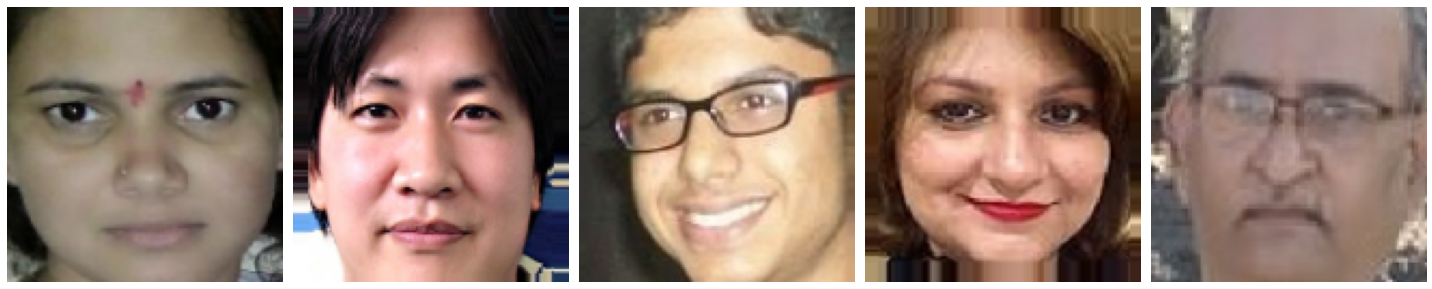

In [76]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_set)
plotImages(sample_training_images[:5])

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization

In [78]:
cnn = Sequential()
cnn.add(Conv2D(32, activation='relu', kernel_size=3, input_shape=[128,128,3]))
# https://www.quora.com/Why-does-batch-normalization-help
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, activation = 'relu', kernel_size = 3))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())
cnn.add(Dense(64, activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Dense(1, activation = 'sigmoid'))

cnn.compile(optimizer='adam', metrics = 'accuracy', loss = 'binary_crossentropy')



In [79]:
cnn.fit(x=train_set, epochs=20, validation_data=val_set)

Epoch 1/20
9/9 [==============================] - 7s 783ms/step - loss: 3.3033 - accuracy: 0.8327 - val_loss: 0.9279 - val_accuracy: 0.7593
Epoch 2/20
9/9 [==============================] - 7s 769ms/step - loss: 3.4570 - accuracy: 0.9217 - val_loss: 2.6413 - val_accuracy: 0.7500
Epoch 3/20
9/9 [==============================] - 7s 796ms/step - loss: 3.0318 - accuracy: 0.9573 - val_loss: 1.7110 - val_accuracy: 0.7500
Epoch 4/20
9/9 [==============================] - 7s 778ms/step - loss: 0.4598 - accuracy: 0.9573 - val_loss: 0.9468 - val_accuracy: 0.7870
Epoch 5/20
9/9 [==============================] - 7s 769ms/step - loss: 0.6556 - accuracy: 0.9715 - val_loss: 2.3056 - val_accuracy: 0.7500
Epoch 6/20
9/9 [==============================] - 7s 767ms/step - loss: 1.7151 - accuracy: 0.9573 - val_loss: 0.8340 - val_accuracy: 0.7685
Epoch 7/20
9/9 [==============================] - 7s 772ms/step - loss: 1.6573 - accuracy: 0.9715 - val_loss: 1.7008 - val_accuracy: 0.6852
Epoch 8/20
9/9 [====

In [80]:
result = cnn.evaluate(test_set)
dict(zip(cnn.metrics_names, result))

2/2 [==============================] - 0s 15ms/step - loss: 5.4896 - accuracy: 0.9268


{'loss': 5.489556312561035, 'accuracy': 0.9268292784690857}